In [23]:
import pandas as pd
import csv
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Load the lung cancer dataset
df = pd.read_excel('lung_expression_data.xlsx').dropna()
df = df[df['GENE'] != 'NULL']

# Load the colon cancer dataset
df_colon = pd.read_excel('colon.xlsx').dropna()
df_colon = df_colon[df_colon['GENE'] != 'NULL']

# Load the leukemia dataset
df_leukemia = pd.read_excel('leukemia.xlsx').dropna()
df_leukemia = df_leukemia[df_leukemia['GENE'] != 'NULL']

In [19]:
# Separate features and target
normal_columns = [col for col in df.columns if col.startswith('LN')]
cancer_columns = [col for col in df.columns if col.startswith(('AD', 'L')) and not col.startswith('LN')]

# Separate features and target for colon cancer
normal_columns_colon = [col for col in df_colon.columns if col.startswith('Normal')]
cancer_columns_colon = [col for col in df_colon.columns if col.startswith('Tumor')]

# Separate features and target for leukemia
normal_columns_leukemia = [col for col in df_leukemia.columns if col.startswith('Normal')]
cancer_columns_leukemia = [col for col in df_leukemia.columns if col.startswith('Cancerous')]

# Perform t-tests
p_values = []
for _, row in df.iterrows():
    cancer_values = row[cancer_columns].astype(float)
    normal_values = row[normal_columns].astype(float)
    p_value = ttest_ind(cancer_values, normal_values).pvalue
    p_values.append(p_value)

df['p_value'] = p_values

# Perform t-tests for colon cancer
p_values_colon = []
for _, row in df_colon.iterrows():
    cancer_values = row[cancer_columns_colon].astype(float)
    normal_values = row[normal_columns_colon].astype(float)
    p_value = ttest_ind(cancer_values, normal_values).pvalue
    p_values_colon.append(p_value)

df_colon['p_value'] = p_values_colon

# Perform t-tests for leukemia
p_values_leukemia = []
for _, row in df_leukemia.iterrows():
    cancer_values = row[cancer_columns_leukemia].astype(float)
    normal_values = row[normal_columns_leukemia].astype(float)
    p_value = ttest_ind(cancer_values, normal_values).pvalue
    p_values_leukemia.append(p_value)

df_leukemia['p_value'] = p_values_leukemia

# Define overexpressed or underexpressed genes based on the p-value and the mean difference
df['is_cancer_mediator'] = ((df['p_value'] < 0.05) & (df[cancer_columns].mean(axis=1) > df[normal_columns].mean(axis=1))).astype(int)

# Define overexpressed or underexpressed genes for colon cancer based on the p-value and the mean difference
df_colon['is_cancer_mediator'] = ((df_colon['p_value'] < 0.05) & (df_colon[cancer_columns_colon].mean(axis=1) > df_colon[normal_columns_colon].mean(axis=1))).astype(int)

# Define overexpressed or underexpressed genes for leukemia based on the p-value and the mean difference
df_leukemia['is_cancer_mediator'] = ((df_leukemia['p_value'] < 0.05) & (df_leukemia[cancer_columns_leukemia].mean(axis=1) > df_leukemia[normal_columns_leukemia].mean(axis=1))).astype(int)

In [22]:
# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(df[cancer_columns + normal_columns], df['is_cancer_mediator'], test_size=0.2, random_state=42)

# Split the colon cancer dataset into a training set and a test set
X_train_colon, X_test_colon, y_train_colon, y_test_colon = train_test_split(df_colon[cancer_columns_colon + normal_columns_colon], df_colon['is_cancer_mediator'], test_size=0.2, random_state=42)

# Split the leukemia dataset into a training set and a test set
X_train_leukemia, X_test_leukemia, y_train_leukemia, y_test_leukemia = train_test_split(df_leukemia[cancer_columns_leukemia + normal_columns_leukemia], df_leukemia['is_cancer_mediator'], test_size=0.2, random_state=42)

# Create a XGBoost Classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)

# Create a XGBoost Classifier for colon cancer
clf_colon = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train_colon, y_train_colon)

# Create a XGBoost Classifier for leukemia
clf_leukemia = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train_leukemia, y_train_leukemia)

# Predict the response for the test dataset
y_pred = clf.predict(X_test)

# Predict the response for the test dataset for colon cancer
y_pred_colon = clf_colon.predict(X_test_colon)

# Predict the response for the test dataset for leukemia
y_pred_leukemia = clf_leukemia.predict(X_test_leukemia)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


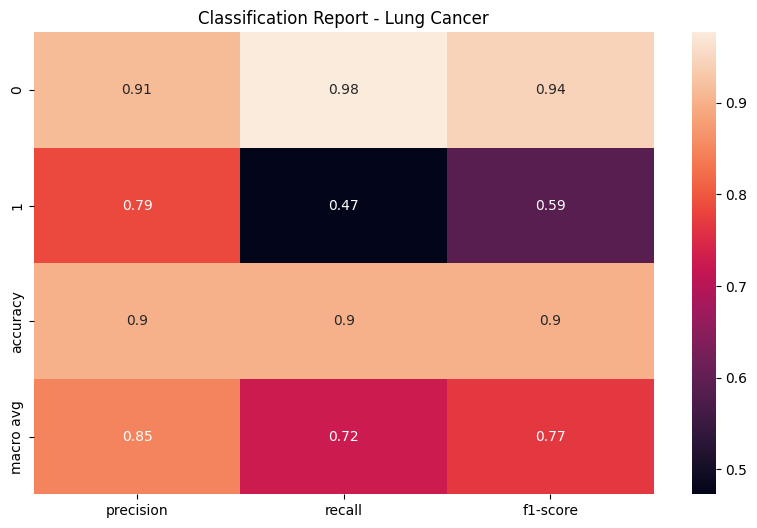

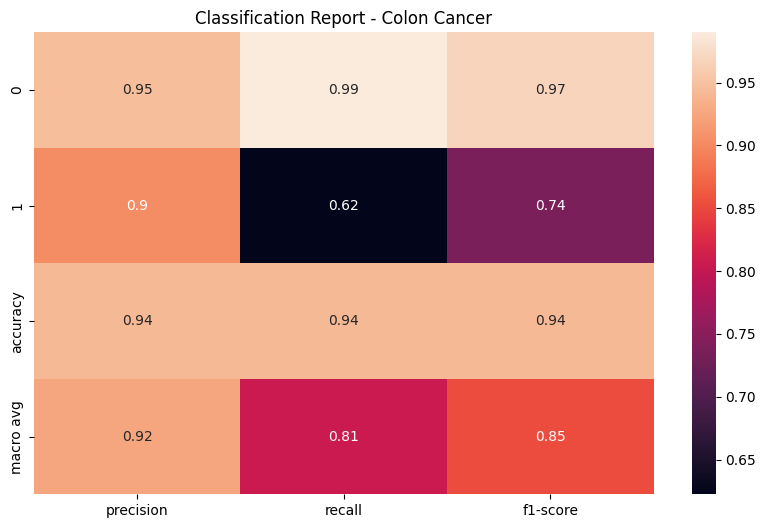

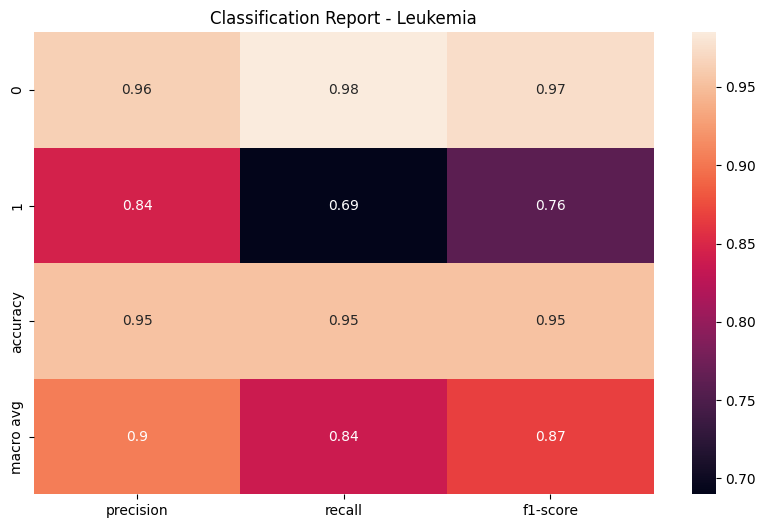

In [24]:
# generate classification reports
report_lung = classification_report(y_test, y_pred, output_dict=True)
report_colon = classification_report(y_test_colon, y_pred_colon, output_dict=True)
report_leukemia = classification_report(y_test_leukemia, y_pred_leukemia, output_dict=True)

# Create a data frame from the dictionaries
df_classification_report_lung = pd.DataFrame(report_lung).transpose()
df_classification_report_colon = pd.DataFrame(report_colon).transpose()
df_classification_report_leukemia = pd.DataFrame(report_leukemia).transpose()


plt.figure(figsize=(10, 6))
sns.heatmap(df_classification_report_lung.iloc[:-1, :-1], annot=True)
plt.title("Classification Report - Lung Cancer")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_classification_report_colon.iloc[:-1, :-1], annot=True)
plt.title("Classification Report - Colon Cancer")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_classification_report_leukemia.iloc[:-1, :-1], annot=True)
plt.title("Classification Report - Leukemia")
plt.show()

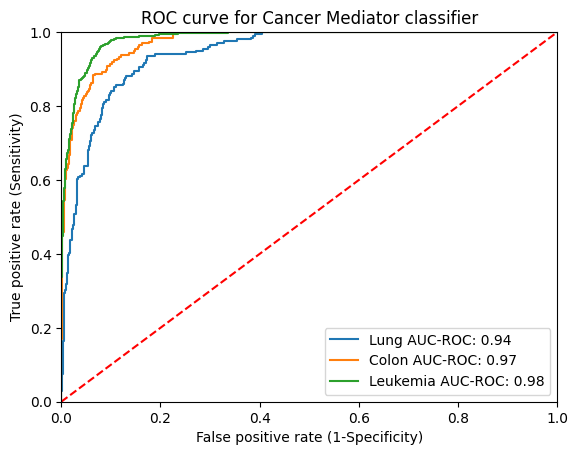

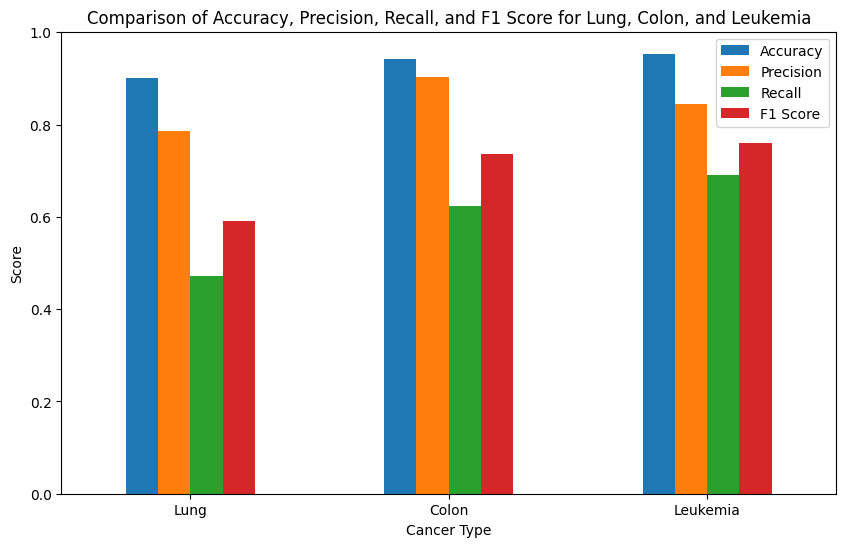

In [21]:
# Plot ROC curve for lung cancer
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Lung AUC-ROC: {roc_auc:.2f}')

# Calculate and plot ROC curve for colon cancer
y_pred_proba_colon = clf_colon.predict_proba(X_test_colon)[:, 1]
fpr_colon, tpr_colon, _ = roc_curve(y_test_colon, y_pred_proba_colon)
roc_auc_colon = roc_auc_score(y_test_colon, y_pred_proba_colon)
plt.plot(fpr_colon, tpr_colon, label=f'Colon AUC-ROC: {roc_auc_colon:.2f}')

# Calculate and plot ROC curve for leukemia
y_pred_proba_leukemia = clf_leukemia.predict_proba(X_test_leukemia)[:, 1]
fpr_leukemia, tpr_leukemia, _ = roc_curve(y_test_leukemia, y_pred_proba_leukemia)
roc_auc_leukemia = roc_auc_score(y_test_leukemia, y_pred_proba_leukemia)
plt.plot(fpr_leukemia, tpr_leukemia, label=f'Leukemia AUC-ROC: {roc_auc_leukemia:.2f}')

# Plot baseline
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Cancer Mediator classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.legend(loc='lower right')
plt.show()

# Calculate metrics for lung cancer
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate metrics for colon cancer
accuracy_colon = accuracy_score(y_test_colon, y_pred_colon)
precision_colon = precision_score(y_test_colon, y_pred_colon)
recall_colon = recall_score(y_test_colon, y_pred_colon)
f1_colon = f1_score(y_test_colon, y_pred_colon)

# Calculate metrics for leukemia
accuracy_leukemia = accuracy_score(y_test_leukemia, y_pred_leukemia)
precision_leukemia = precision_score(y_test_leukemia, y_pred_leukemia)
recall_leukemia = recall_score(y_test_leukemia, y_pred_leukemia)
f1_leukemia = f1_score(y_test_leukemia, y_pred_leukemia)

# Create a dataframe to hold the metrics for both lung and colon cancer
metrics_df = pd.DataFrame({
    'Cancer Type': ['Lung', 'Colon', 'Leukemia'],
    'Accuracy': [accuracy, accuracy_colon, accuracy_leukemia],
    'Precision': [precision, precision_colon, precision_leukemia],
    'Recall': [recall, recall_colon, recall_leukemia],
    'F1 Score': [f1, f1_colon, f1_leukemia]
})

# Plot the metrics in a bar graph
metrics_df.set_index('Cancer Type').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Accuracy, Precision, Recall, and F1 Score for Lung, Colon, and Leukemia')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

In [14]:
# Predict on the whole dataset to find all potential cancer mediating genes
df['predicted'] = clf.predict(df[cancer_columns + normal_columns])

# Export the predicted genes to a csv file
df.loc[df['predicted'] == 1, 'GENE'].to_csv('predicted_genes.csv', index=False)

In [15]:
# Read the CSV file into a list of lists
with open('newncbi_Lung.csv', 'r') as f:
    genes_and_aliases = [item.strip().upper() for sublist in csv.reader(f) for item in sublist]

# Check each predicted gene to see if it appears in the list of genes or aliases
predicted_genes = set(df.loc[df['predicted'] == 1, 'GENE'])
matches = predicted_genes.intersection(genes_and_aliases)
print(matches)

# Print the number of matches and non-matches
print(f"Out of {len(predicted_genes)} predicted genes, {len(matches)} were matched and {len(predicted_genes) - len(matches)} were not matched.")

{'ERCC1', 'PHB', 'ATM', 'ECGF1', 'HSPD1', 'KRT19', 'BMP7', 'KRT18', 'COL1A2', 'ADPRT', 'RB1', 'MEN1', 'MDK', 'ETV4', 'VEGF', 'TYMS', 'EZH2', 'MAP2', 'CEACAM5', 'BCL2', 'TGIF', 'ITGA2', 'GALNT3', 'RORC', 'SDC1', 'CDH3', 'CTNND1', 'SERPINH2', 'TK1', 'KOC1', 'FAP', 'ABCE1', 'SHC1', 'PAK1', 'MIF', 'CXADR', 'ERBB3', 'CEACAM1', 'ITGAV', 'CYP17', 'UBCH10', 'KPNA2', 'SLC2A1', 'SKP2', 'NEK2', 'E2F1', 'NME1', 'FOXM1', 'HK2', 'D6S52E', 'NRAS', 'MRE11A', 'CAP', 'HDAC1', 'TOP2A', 'CRABP1', 'LAMC2', 'CCNA2', 'SMARCA4', 'ALOX15', 'SPP1', 'MST1R', 'CDKN3', 'HSPB1', 'ATIC', 'FADD', 'APEX', 'TNFSF6', 'ADAM15', 'CD24', 'TACSTD2', 'XRCC4', 'XBP1', 'BCL2L1', 'IREB2', 'SKB1', 'RRM2', 'EEF1A2', 'RELA', 'ARHGEF5', 'GSTP1', 'TFAP2A', 'MAD2L1', 'SIX1', 'S100P', 'COL5A1', 'ITGB4', 'NMU', 'DNMT1', 'SPK', 'CENPA', 'SLC2A5', 'IGFBP3', 'TACSTD1', 'ABCC1', 'TUBB4', 'CDH1', 'VDR', 'MMP12', 'KRT7', 'SHMT1', 'CYP2A6', 'ELAVL1', 'DYRK2', 'TRAF2', 'PLK', 'TP73', 'YAP65', 'ADAM8', 'BIRC5', 'VHL', 'LAMB3', 'HE4', 'CDC6', 'H